In [1]:
#Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
data=pd.read_csv("mnist_dataset.csv")
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
image=data.iloc[3] #selecting image at 3
image=np.array(image).astype("float32")
image=np.reshape(image, (28,28)) # reshaping from 1d to 2d 
image=image/255 #scaling 0-1

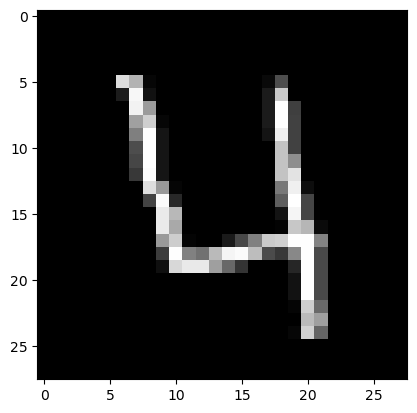

In [11]:
plt.imshow(image, cmap="gray")

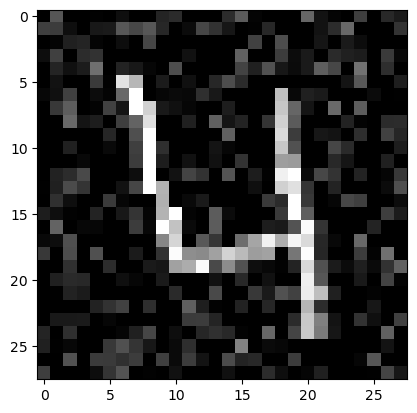

In [13]:
#turning the image noisy to be able to remove noise
noisy_image=image+0.2*np.random.randn(*image.shape) #adding noise
noisy_image = np.clip(noisy_image,0,1) #making sure the image pixels are between 0 and 1
plt.imshow(noisy_image, cmap="gray")

## Data preparation

In [15]:
#Adding noise to the whole dataset
#Library input
from torch.utils.data import Dataset
import matplotlib.pyplot as plt #The helper functions are taken from the codebase of the tutor, these are below

import numpy as np 
import torch

#The helper functions are taken from the codebase of the tutor, these are below


def show_image(noisy_image,org_image,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('noisy_image')
        ax1.imshow(noisy_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('original_image')
        ax2.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('noisy_image')
        ax1.imshow(noisy_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('original_image')
        ax2.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('denoised_image')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        
class ToTensorForAE(object):
    
    def __call__(self,sample):
        
        images,labels = sample
        
        images = images.transpose((2,0,1))
        labels = labels.transpose((2,0,1))
        
        return torch.from_numpy(images).float(),torch.from_numpy(labels).float()

In [17]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self, csv_file, noise_factor=0.2, transform = None):
        
        self.data=pd.read_csv(csv_file)
        self.noise_factor=noise_factor
        self.transform=transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img, (28,28,1)) /255 #length, width, levels (1 because we use greyscale)
        
        noisy_image = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_image = np.clip(noisy_image,0,1)
        
        sample = (noisy_image, img)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample


In [18]:
trainset = MNIST_AE_Dataset("mnist_dataset.csv", transform=ToTensorForAE())

In [26]:
print("The size of the trainset is : {}".format(len(trainset)))
#These are the images themselves

The size of the trainset is : 42000


In [27]:
noisy_image, img = trainset[18]

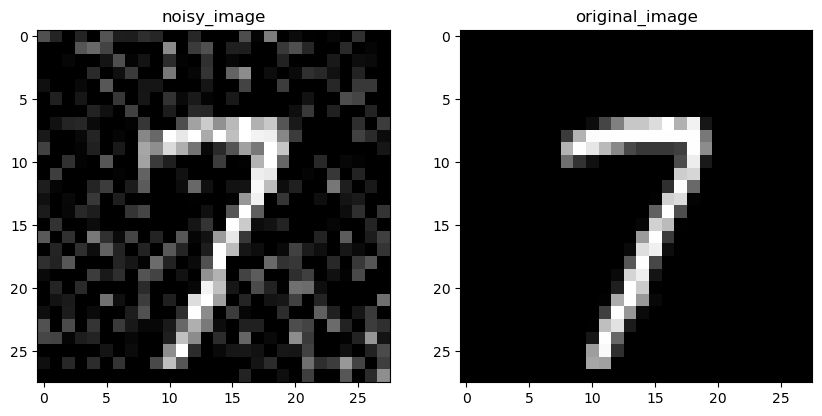

In [33]:
show_image(org_image=img, noisy_image=noisy_image)

## Load dataset into batches

In [34]:
from torch.utils.data import DataLoader

In [35]:
trainloader= DataLoader(trainset, batch_size=16, shuffle = True)

In [38]:
#for noisy_image, img in trainloader:...   #this would be for loading everything, as we want to use
# batch loading we use:
dataiter = iter(trainloader)
noisy_image, img = next(dataiter)
print("Shape of loading one batch: {}".format(noisy_image.shape))
print("Total number of batches: {}".format(len(trainloader)))
print("Total number of images in the dataset: {}".format(len(trainloader.dataset)))

Shape of loading one batch: torch.Size([16, 1, 28, 28])
Total number of batches: 2625
Total number of images in the dataset: 42000


## Create autoencoder model

In [41]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [42]:
from torch import nn
from torchsummary import summary

In [68]:
def Encoder():
    enc=nn.Sequential(
        
        nn.Conv2d(in_channels=1,out_channels=16, kernel_size=(3,3), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=16,out_channels=32, kernel_size=(3,3), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
    )
    return enc

In [69]:
def Decoder():
    dec = nn.Sequential(
    nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(2,2), stride = 2),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(2,2), stride = 2),
    nn.Sigmoid()
    )
    return dec

In [70]:
from torchsummary import summary

# ... (Encoder and Decoder definitions)

# Connect the layers and create the autoencoder
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
    
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, inp_imgs):
        encoder_out = self.encoder(inp_imgs)
        decoder_out = self.decoder(encoder_out)
        
        return decoder_out

model = AutoEncoder()

summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

In [71]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [72]:
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

## Train AutoEncoder Model

In [73]:
from tqdm import tqdm #used to show loop progress, just put it around the range

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
epochs = 10


In [76]:
for i in tqdm(range(epochs)): #tqdm is used to show progress
    train_loss=0.0
    model.train()
    for batch in trainloader:
        noisy_image, img = batch
        denoise_image= model(noisy_image)
        loss= criterion(denoise_image, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    avg_train_loss = train_loss/len(trainloader)
    
    print("epoch : {} Train loss : {} ". format(i+1, avg_train_loss))
        

 10%|██████▍                                                         | 1/10 [00:26<04:00, 26.74s/it]

epoch : 1 Train loss : 0.005381235215458132 


 20%|████████████▊                                                   | 2/10 [00:51<03:23, 25.43s/it]

epoch : 2 Train loss : 0.005038210211144317 


 30%|███████████████████▏                                            | 3/10 [01:12<02:43, 23.34s/it]

epoch : 3 Train loss : 0.004858080016803884 


 40%|█████████████████████████▌                                      | 4/10 [01:32<02:12, 22.14s/it]

epoch : 4 Train loss : 0.004759153662959025 


 50%|████████████████████████████████                                | 5/10 [02:00<02:01, 24.21s/it]

epoch : 5 Train loss : 0.004674654650191466 


 60%|██████████████████████████████████████▍                         | 6/10 [02:25<01:38, 24.54s/it]

epoch : 6 Train loss : 0.004612635281735233 


 70%|████████████████████████████████████████████▊                   | 7/10 [02:52<01:16, 25.34s/it]

epoch : 7 Train loss : 0.004575598614379054 


 80%|███████████████████████████████████████████████████▏            | 8/10 [03:20<00:52, 26.22s/it]

epoch : 8 Train loss : 0.004538816334591025 


 90%|█████████████████████████████████████████████████████████▌      | 9/10 [03:45<00:25, 25.67s/it]

epoch : 9 Train loss : 0.004503044821144569 


100%|███████████████████████████████████████████████████████████████| 10/10 [04:13<00:00, 25.32s/it]

epoch : 10 Train loss : 0.004483645121433905 


torch.Size([1, 28, 28])


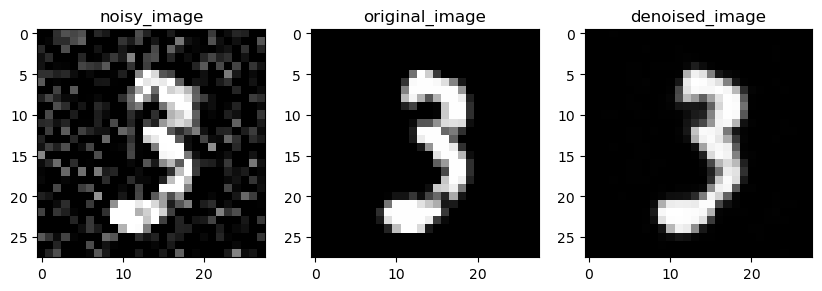

In [80]:
model.eval()

with torch.no_grad():
    
    dataiter= iter(trainloader)
    sample = next(dataiter)
    noisy_image, img = sample 
    
    index = 2
    
    denoised_img= model(noisy_image[index].unsqueeze(0))
    print(denoised_img.squeeze(0).shape)
    
    show_image(noisy_image[index], img[index], denoised_img.squeeze(0))